In [1]:
import numpy as np
import optuna
from dask.distributed import Client, wait
from optuna.integration.dask import DaskStorage
import sys
sys.path.insert(1, 'bin/capstonecompetition/')
from capstone import CapstoneObjective
from capvisual import CapstoneVisual
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

Function 3: **Drug Discovery Problem.** In this example, you are doing drug discovery! You can select three compounds to create a drug, and receive a measurement of the people’s adverse reaction to the drug. You want to make this as close as possible to zero. (hint: one of the variables may not cause any effects on the person).

### 1. Setup Environment

In [2]:
# Cluster URL - set to None if using just a local client
GLBL_dask_cluster_url = 'tcp://10.0.4.87:8786'
#GLBL_dask_cluster_url = None
GLBL_dask_n_futures = 100
GLBL_dask_upload_file = 'bin/capstonecompetition/capstone.py'
GLBL_optuna_n_trials = 20
GLBL_optuna_study_name = 'f3_GaussianProcessRegressor'
GLBL_optuna_direction = ["maximize", "minimize", "maximize"]
GLBL_optuna_storage = 'mysql://test@localhost/optuna'

# Load the data
X = np.load('update_data/function_3/update_inputs.npy')
Y = np.load('update_data/function_3/update_outputs.npy')

# Load the capstone objective function
optrun = CapstoneObjective(X, Y, 3)

# Load the best observation in case we need it here...
observation_x = optrun.get_best_observe_x()

# Set up a basic grid for the function
X_grid = optrun.get_grid_for_func()

### 2. Visualize the latest Data

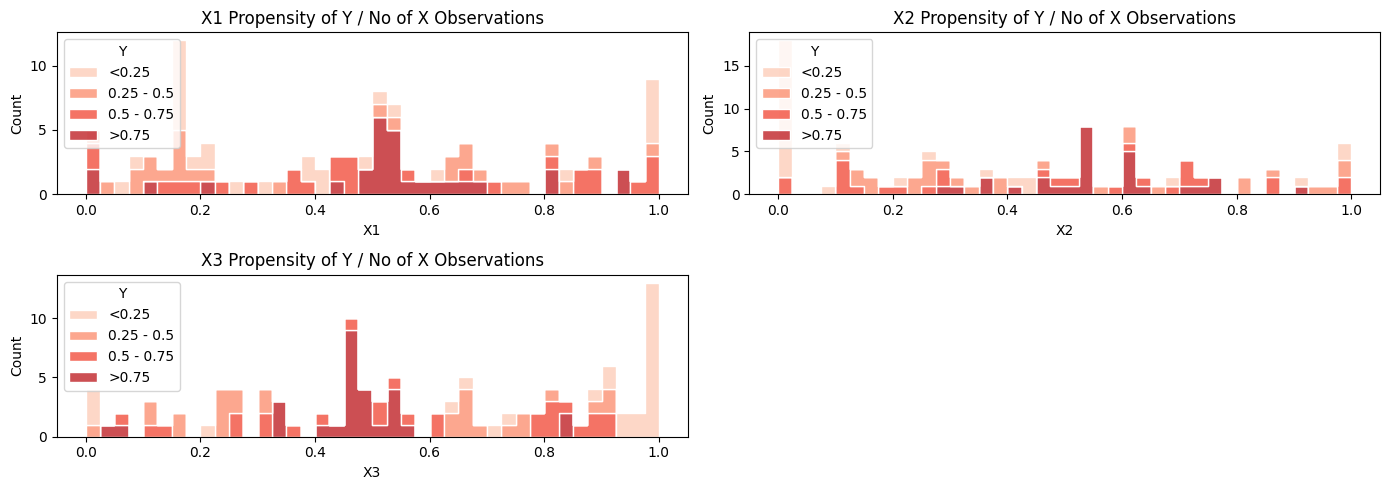

In [3]:
# Create another object for visualisation (not pickled in the cluster)
optview = CapstoneVisual(optrun)
optview.plot_distribution()

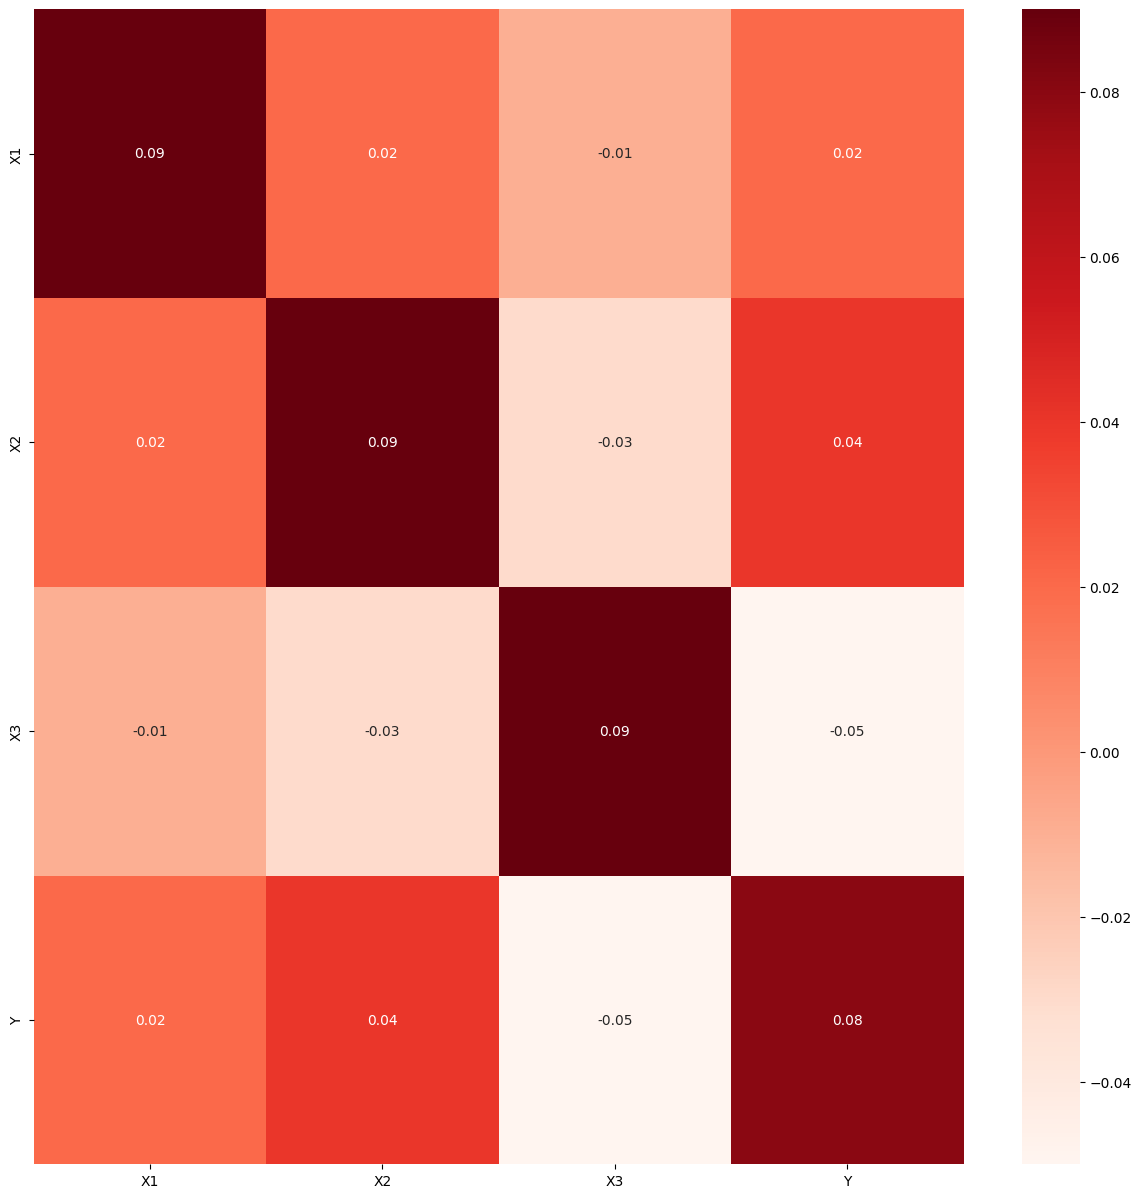

In [4]:
optview.plot_covariance()

In [5]:
optview.return_parellelmap()

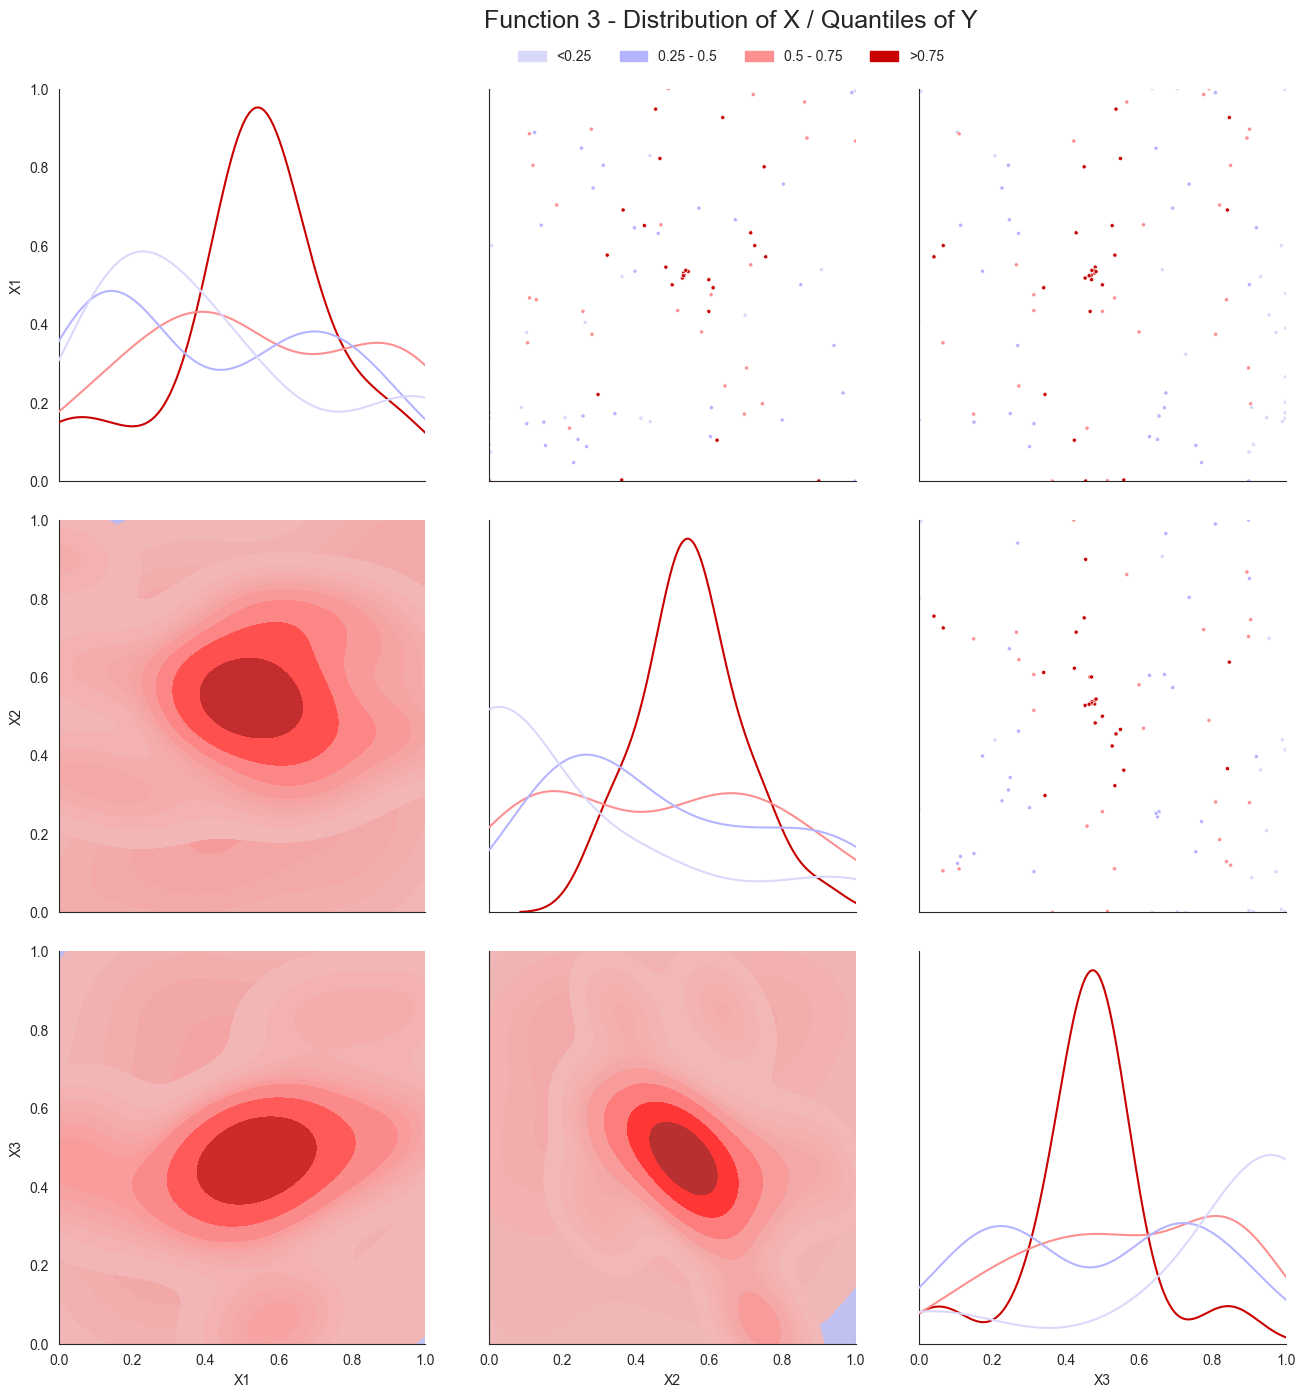

In [6]:
optview.return_scatterpairplot()

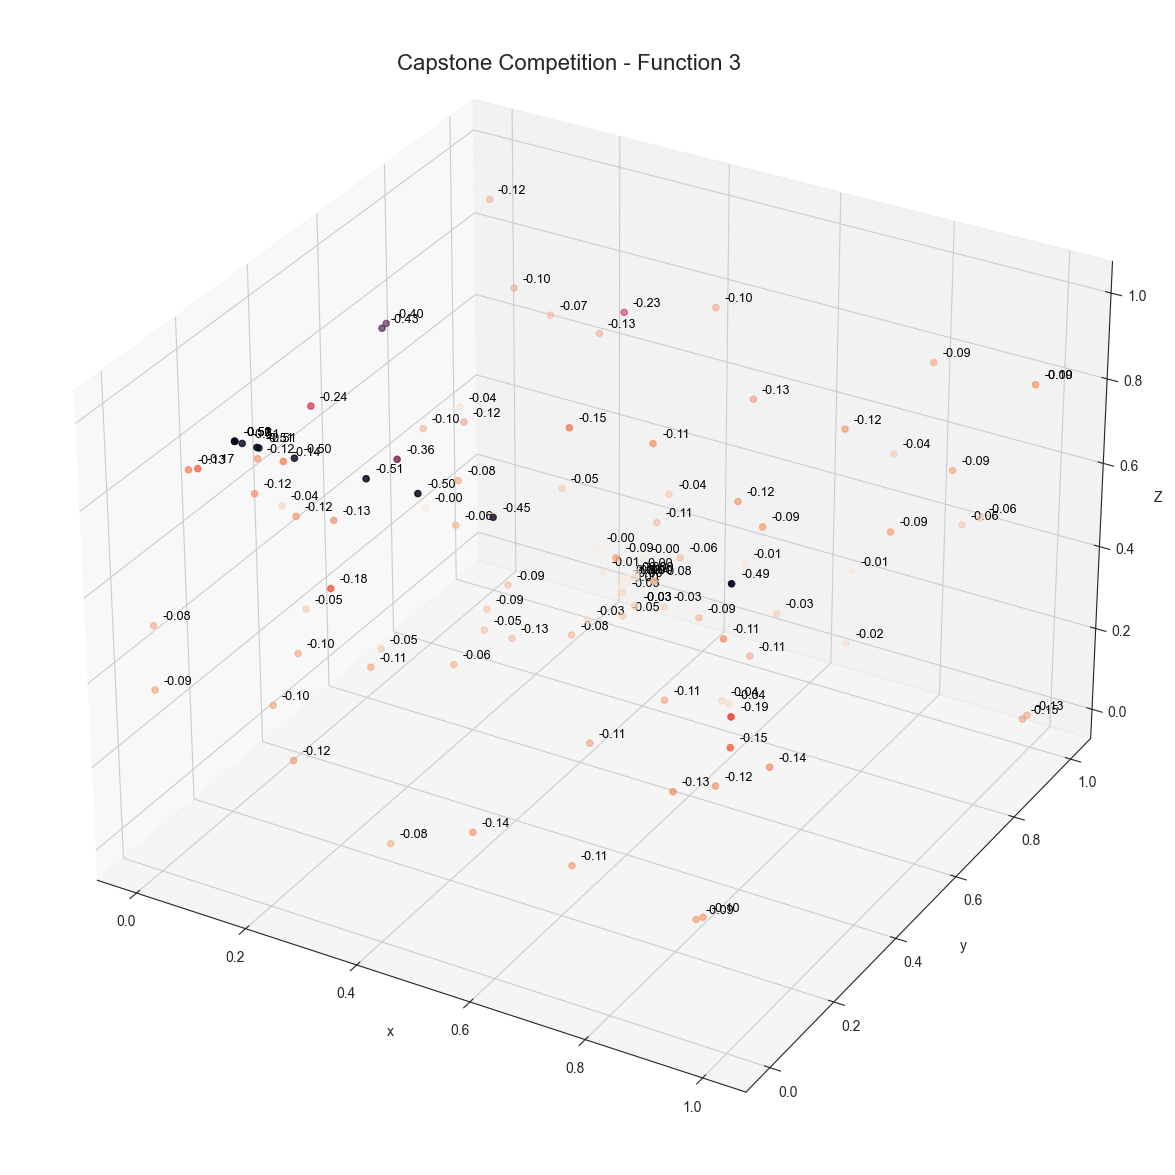

In [7]:
optview.plot_3d()

In [8]:
df = optview.return_as_pandas()
df.sort_values(by='Y', ascending=False).head(10)

X1        X2        X3             Y
71   0.519622  0.530912  0.468558 -0.0002530260
100  0.524501  0.533461  0.469730 -0.0002721547
93   0.536937  0.537095  0.471463 -0.0003158851
98   0.432323  0.600000  0.466667 -0.0005675872
64   0.537220  0.539058  0.477449 -0.0006252266
104  0.513131  0.600000  0.470707 -0.0007017883
49   0.530233  0.531118  0.479103 -0.0007930242
85   0.533952  0.543693  0.482770 -0.0009997583
78   0.517332  0.527787  0.453002 -0.0021234259
107  0.523214  0.530589  0.463825 -0.0021355791

### 3. Hyperparameter Optimization over the Dask Cluster

In [9]:
# Build a Dask Client
client = Client(GLBL_dask_cluster_url)
client.upload_file(GLBL_dask_upload_file)
storage = DaskStorage(client=client)

# Build the Optuna study
study = optuna.create_study(storage=storage, study_name=GLBL_optuna_study_name, directions=GLBL_optuna_direction)

# Build the futures for the Dask Client
futures = [
    client.submit(study.optimize, optrun, n_trials=GLBL_optuna_n_trials, pure=False)
    for _ in range(GLBL_dask_n_futures)
]

# Run the Dask futures
client.gather(futures)
wait(futures)
client.cancel(futures)

/var/folders/0x/s197kd456h5gfsxy568y34p00000gn/T/ipykernel_3806/3240579904.py:4: ExperimentalWarning:

DaskStorage is experimental (supported from v3.1.0). The interface can change in the future.



In [10]:
# Return the study findings
optrun.get_studyresults(study)

Choosen Trial: 
	_number: 1606
	state: 1
	_values: [176.58850750056314, 0.03654060770101606, 0.9181818794536603]
	_datetime_start: 2024-04-15 15:56:09.838629
	datetime_complete: 2024-04-15 15:56:37.330788
	_params: {'kernel': 'quad', 'd_quad_lbound': 0.0001, 'd_quad_rbound': 100000.0, 'd_quad_lscale': 3.7964923709343648, 'd_quad_wht_noise': 3.296305329158477}
	_user_attrs: {}
	_system_attrs: {'nsga2:generation': 21}
	intermediate_values: {}
	_distributions: {'kernel': CategoricalDistribution(choices=('rbf', 'rbf-white', 'const', 'quad', 'matern', 'sineexp')), 'd_quad_lbound': CategoricalDistribution(choices=(1e-07, 1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1)), 'd_quad_rbound': CategoricalDistribution(choices=(10000000.0, 1000000.0, 100000.0, 10000.0, 1000.0, 100.0, 10.0)), 'd_quad_lscale': FloatDistribution(high=10.0, log=False, low=0.1, step=None), 'd_quad_wht_noise': FloatDistribution(high=10.0, log=False, low=0.05, step=None)}
	_trial_id: 1606


### 4. Explore the Best Model

In [11]:
# Run the best model (above) against the standard grid...this returns UCB, PI and EI as well as distances from other points
optrun.run_model(study, X_grid, label='Grid Search')

/Users/adz/venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.



-f3----------------------- Grid Search (1481544, 3) -----------------------f3-
                            x1                     x2                     x3
-------  ---------------------  ---------------------  ---------------------
UCB 95%  1.0000000000000000000  0.6460176991150442527  0.4159292035398229892
UCB 90%  1.0000000000000000000  0.6371681415929203451  0.4247787610619468968
UCB 0%   0.5044247787610619538  0.2212389380530973559  0.7168141592920354022
PI       0.4955752212389380462  0.2123893805309734484  0.7345132743362832173
EI       0.0000000000000000000  0.6902654867256636795  0.3805309734513274145
BEST     0.5196220000000000283  0.5309120000000000505  0.4685579999999999745
              dist(max(x))                dist(x)
---  ---------------------  ---------------------
UCB  0.3971894780270342484  0.1583035641810331406
PI   0.4156526369812676425  0.1372722985832062204
EI   0.5505899690501334653  0.1314158151037691513
----------------------- Kernel -----------------------


### 5. Exploration - Create a Voronoi Dataset

In [12]:
# Let's look at exploration, run a Voronoi model and return the distances. 
df_vor = optview.get_voronoi_table(study)
df_vor.sort_values(by='Y', ascending=False).head(10)

/Users/adz/venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.



X1            X2            X3  dist(max(x))       dist(x)  \
171  0.4731129559  0.5616608148  0.4609671177  0.0562690171  0.0562690171   
281  0.5082179125  0.5651415136  0.4551000866  0.0385075090  0.0385075090   
282  0.5102192806  0.5610701356  0.4556233525  0.0341354564  0.0341354564   
283  0.5137530793  0.5661270869  0.4523936212  0.0391897145  0.0385115705   
280  0.5040994943  0.5641545104  0.4743915832  0.0371489350  0.0371489350   
278  0.5230280830  0.5676304584  0.4579452647  0.0383728647  0.0361745955   
279  0.5241477043  0.5679495716  0.4492417062  0.0420164601  0.0401167867   
250  0.5261776726  0.5686666274  0.4449837302  0.0449903871  0.0425873515   
289  0.5278011620  0.5441657798  0.4728977358  0.0161677047  0.0116412168   
284  0.5131853059  0.5416846062  0.4854377530  0.0210334528  0.0210334528   

                Y  
171  0.0057877495  
281  0.0057400713  
282  0.0055333506  
283  0.0053700917  
280  0.0052605133  
278  0.0048936768  
279  0.0045444172  
250  0.0040755042  
289  0.0017826273  
284  0.0015914057

In [13]:
# We can run our model on all the Voronoi vertices to return the choices of the explorative points.
optrun.run_model(study, optview.get_vertices(), label='Voronoi Vertices')

-f3----------------------- Voronoi Vertices (364, 3) -----------------------f3-
                            x1                     x2                     x3
-------  ---------------------  ---------------------  ---------------------
UCB 95%  0.5024087163626471675  0.2260993664624336152  0.6801960502404555964
UCB 90%  0.5024087163626471675  0.2260993664624336152  0.6801960502404555964
UCB 0%   0.5024087163626471675  0.2260993664624336152  0.6801960502404555964
PI       0.5024087163626471675  0.2260993664624336152  0.6801960502404555964
EI       0.5024087163626471675  0.2260993664624336152  0.6801960502404555964
BEST     0.5196220000000000283  0.5309120000000000505  0.4685579999999999745
----------------------- Trial 1606 Report -----------------------
Previous Best Point: -0.00025302602839520985
	Trail LML: 176.58850750056314
	RMSE: 0.03654060770101606
	F2 SCORE: 0.9181818794536603
	Best Observed Point: 0.005787749507474001
	GPR Log Marginal Likelihood: 176.5885075005657
-f3-----------

/Users/adz/venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.



### 6. Exploitation - Converge on objective points

In [14]:
# Let's sample from inside a Voronoi region or in a finer grid
objective_point = observation_x # This is the best observation
pulsar, simplex = optview.create_pulsargrid(study, objective_point)
pulsar.sort_values(by='Y', ascending=False).head(10)

/Users/adz/venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.



X1        X2        X3  dist(max(x))       dist(x)             Y
2947  0.485671  0.561661  0.468558  0.0458058010  0.0458058010  0.0060932506
2953  0.485690  0.561644  0.468558  0.0457803063  0.0457803063  0.0060931642
2958  0.485709  0.561626  0.468558  0.0457541404  0.0457541404  0.0060930621
2964  0.485728  0.561609  0.468558  0.0457286458  0.0457286458  0.0060929689
2968  0.485747  0.561592  0.468558  0.0457031511  0.0457031511  0.0060928724
2975  0.485766  0.561575  0.468558  0.0456776565  0.0456776565  0.0060927725
2980  0.485785  0.561557  0.468558  0.0456514906  0.0456514906  0.0060926563
2984  0.485804  0.561540  0.468558  0.0456259960  0.0456259960  0.0060925496
2990  0.485823  0.561523  0.468558  0.0456005013  0.0456005013  0.0060924396
2997  0.485842  0.561506  0.468558  0.0455750067  0.0455750067  0.0060923263

In [15]:
# return a parallel cordinates map of the best predictions - manually this is a good tool for investigation
optview.return_parellelmap(pulsar[pulsar['Y'] > 0.00609])

In [16]:
# Pipe these samples back into the model if we needed UCB, PI and EI
optrun.run_model(study, pulsar.iloc[:,:3].to_numpy(), label='Pulsar Grid')

/Users/adz/venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.



-f3----------------------- Pulsar Grid (49995, 3) -----------------------f3-
                            x1                     x2                     x3
-------  ---------------------  ---------------------  ---------------------
UCB 95%  0.4527820000000000178  0.5361930000000000307  0.4690759999999999930
UCB 90%  0.4527820000000000178  0.5361930000000000307  0.4690759999999999930
UCB 0%   0.4731130000000000058  0.5616609999999999658  0.4609670000000000156
PI       0.4731130000000000058  0.5616609999999999658  0.4609670000000000156
EI       0.4527820000000000178  0.5361930000000000307  0.4690759999999999930
BEST     0.5196220000000000283  0.5309120000000000505  0.4685579999999999745
----------------------- Trial 1606 Report -----------------------
Previous Best Point: -0.00025302602839520985
	Trail LML: 176.58850750056314
	RMSE: 0.03654060770101606
	F2 SCORE: 0.9181818794536603
	Best Observed Point: 0.006093250600350076
	GPR Log Marginal Likelihood: 176.5885075005657
-f3--------------

### 7. Exploitation - Manual evaluation of the best points

In [17]:
# Or we can run the model manually on the best points
points_to_evaluate = [0.473113,0.561660,0.4609670]
optrun.run_model(study, np.array([points_to_evaluate]), label='Choosen Point')

-f3----------------------- Choosen Point (1, 3) -----------------------f3-
                            x1                     x2                     x3
-------  ---------------------  ---------------------  ---------------------
UCB 95%  0.4731130000000000058  0.5616600000000000481  0.4609670000000000156
UCB 90%  0.4731130000000000058  0.5616600000000000481  0.4609670000000000156
UCB 0%   0.4731130000000000058  0.5616600000000000481  0.4609670000000000156
PI       0.4731130000000000058  0.5616600000000000481  0.4609670000000000156
EI       0.4731130000000000058  0.5616600000000000481  0.4609670000000000156
BEST     0.5196220000000000283  0.5309120000000000505  0.4685579999999999745
----------------------- Trial 1606 Report -----------------------
Previous Best Point: -0.00025302602839520985
	Trail LML: 176.58850750056314
	RMSE: 0.03654060770101606
	F2 SCORE: 0.9181818794536603
	Best Observed Point: 0.005787718055936209
	GPR Log Marginal Likelihood: 176.5885075005657
-f3----------------

/Users/adz/venv/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:424: ConvergenceWarning:

The optimal value found for dimension 0 of parameter k1__k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.

